# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [46]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [47]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [48]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 9009 / 11441 MB available


In [49]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel(float* c, float* a, float* b, int cols) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    // Pseudocode
    // c[j][i] = a[j][i] + b[j][i]
    unsigned int k = j * cols + i;
    
    c[k] = a[k] + b[k];
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addMatrixKernel");



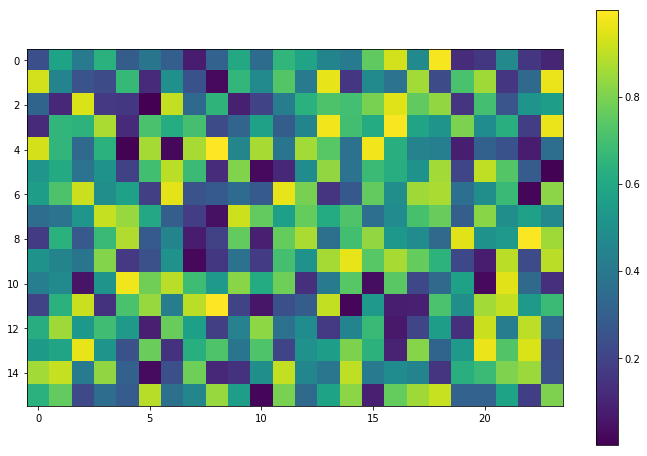

In [50]:
#Size of our test
test_size = (16, 24)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random(test_size).astype(np.float32)
c = np.empty_like(a)

fig = plt.figure(figsize=(12,8))
plt.imshow(a)
plt.colorbar()
fig.show()

In [51]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

In [52]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [53]:
#a.shape = [rows, columns] => [y, x]
domain_size = (a.shape[1], a.shape[0])
block_size = (8, 4, 1)#these need to be [x, y, z]
grid_size = (domain_size[0] // block_size[0], domain_size[1] // block_size[1], 1)

print("Domain size is " + str(domain_size))
print("Block size is " + str(block_size))
print("Grid size is " + str(grid_size))

Domain size is (24, 16)
Block size is (8, 4, 1)
Grid size is (3, 4, 1)


In [59]:
#Execute program on device 
kernel(c_g, a_g, b_g, np.int32(domain_size[0]), block=block_size, grid=grid_size)

#Copy data from device to host 
c_g.get(c)

array([[0.6956429 , 0.841446  , 1.3983978 , 1.285835  , 0.83706605,
        0.71610844, 1.1316993 , 0.37471953, 1.1401596 , 1.5666219 ,
        1.112846  , 1.2582219 , 0.72973585, 1.1122998 , 1.0041381 ,
        1.3813745 , 1.3979583 , 0.7580409 , 1.403221  , 0.3691594 ,
        0.9590585 , 1.172891  , 0.3383187 , 0.5816625 ],
       [1.3993813 , 1.3977745 , 0.93558705, 0.37102005, 0.94074   ,
        0.470458  , 0.51002014, 0.9394821 , 0.14337751, 1.4792442 ,
        1.1292748 , 1.5361241 , 0.8656486 , 1.5326238 , 0.44791234,
        1.2360255 , 0.54266036, 1.3975059 , 0.51349986, 0.91632706,
        1.6197228 , 1.107997  , 0.80434763, 1.7933236 ],
       [0.8608991 , 0.12042236, 0.9548527 , 0.93102765, 1.1006222 ,
        0.7634123 , 1.120172  , 0.83354986, 1.1274233 , 0.9493802 ,
        0.9635695 , 1.0777266 , 1.6155121 , 1.4948566 , 0.75158393,
        1.0674334 , 1.7340282 , 1.0949546 , 0.9942847 , 0.6936215 ,
        1.0477324 , 1.0546738 , 0.939283  , 1.3691425 ],
       [0.318

#Execute program on device 
kernel(c_g, a_g, b_g, np.int32(domain_size[1]) dblock=block_size, grid=grid_size)

#Copy data from device to host 
c_g.get(c)

#Execute program on device
kernel(c_g, a_g, b_g, np.int32(domain_size[1])), dblock=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

In [60]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[0.6956429  0.841446   1.3983978  1.285835   0.83706605 0.71610844
  1.1316993  0.37471953 1.1401596  1.5666219  1.112846   1.2582219
  0.72973585 1.1122998  1.0041381  1.3813745  1.3979583  0.7580409
  1.403221   0.3691594  0.9590585  1.172891   0.3383187  0.5816625 ]
 [1.3993813  1.3977745  0.93558705 0.37102005 0.94074    0.470458
  0.51002014 0.9394821  0.14337751 1.4792442  1.1292748  1.5361241
  0.8656486  1.5326238  0.44791234 1.2360255  0.54266036 1.3975059
  0.51349986 0.91632706 1.6197228  1.107997   0.80434763 1.7933236 ]
 [0.8608991  0.12042236 0.9548527  0.93102765 1.1006222  0.7634123
  1.120172   0.83354986 1.1274233  0.9493802  0.9635695  1.0777266
  1.6155121  1.4948566  0.75158393 1.0674334  1.7340282  1.0949546
  0.9942847  0.6936215  1.0477324  1.0546738  0.939283   1.3691425 ]
 [0.31899995 0.6972499  1.0465322  1.3711846  0.1558276  0.76435626
  0.6900214  1.4786918  0.6860862  0.37544054 1.0081105  0.9005947
  0.61174476 1.9219332  1.5553308  0.72354025 1.

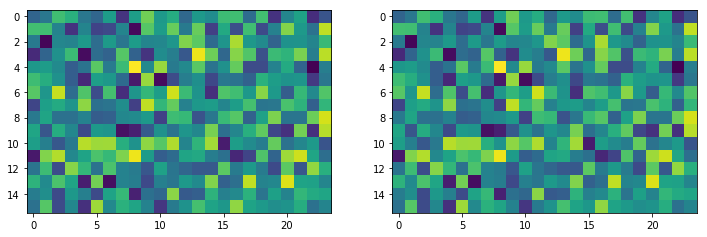

In [61]:
fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(c)
plt.subplot(1, 2, 2)
plt.imshow(c_ref)